# CAPTCHA Recognition Using Deep Learning
This notebook builds and trains a model to recognize text in CAPTCHA images. It uses datasets with labeled CAPTCHA images, preprocesses the data, and implements a ResNet-like architecture for training and evaluation.

## Importing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from kagglehub import dataset_download
from tqdm import tqdm

# Set seeds for reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Configuration and Dataset Paths

In [2]:
# Configuration
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 100
INITIAL_LEARNING_RATE = 1e-4

# Dataset paths
dataset1_path = dataset_download("tomtillo/5000-labelled-captcha-for-deeplearning")
dataset2_path = dataset_download("mrigaankjaswal/capcha-images-to-training-data")

## Load and Preprocess Dataset 1
### Explanation
1. Read images and labels from dataset.
2. Resize images to a fixed size.
3. Normalize pixel values to the range [0, 1].

In [3]:
X1, y1 = [], []
for level in range(1, 6):
    images = []
    labels = []
    image_folder = os.path.join(dataset1_path, f"level_{level}")
    label_file = os.path.join(dataset1_path, f"labels_level_{level}.csv")

    df = pd.read_csv(label_file, header=None, names=["filename", "label"])
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_folder, row["filename"])
        if os.path.exists(image_path):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
            images.append(img)
            labels.append(str(row["label"]))
    X1.append(images)
    y1.extend(labels)

X1 = np.concatenate(X1, axis=0)
X1 = X1 / 255.0
X1 = X1.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)

100%|██████████| 10001/10001 [00:44<00:00, 223.00it/s]


## Load and Preprocess Dataset 2

In [4]:
X2, y2 = [], []
for filename in tqdm(os.listdir(dataset2_path)):
    if filename.endswith(".png"):
        image_path = os.path.join(dataset2_path, filename)
        label = filename.split(".png")[0]
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        X2.append(img)
        y2.append(label)

X2 = np.array(X2)
X2 = X2 / 255.0
X2 = X2.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)

100%|██████████| 1/1 [00:00<00:00, 9845.78it/s]


## Combine and Encode Datasets
### Explanation
1. Combine datasets.
2. Encode labels as one-hot vectors.
3. Pad labels to the maximum length.

In [5]:
# Combine datasets
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

# Character encoding
char_set = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
char_to_int = {char: idx for idx, char in enumerate(char_set)}
int_to_char = {idx: char for char, idx in char_to_int.items()}
num_classes = len(char_set)
max_length = max(len(label) for label in y)

# Encode labels
encoded_labels = np.zeros((len(y), max_length, num_classes))
for i, label in enumerate(y):
    for j, char in enumerate(label):
        if j < max_length:
            encoded_labels[i, j, char_to_int[char]] = 1

## Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_labels, test_size=0.2, random_state=42
)

## Define ResNet-like Model

In [7]:
def residual_block(x, filters, kernel_size=3, downsample=False):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        shortcut = layers.Conv2D(filters, 1, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(x.shape[-1], 1, padding='same', kernel_regularizer=regularizers.l2(1e-4))(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 128, downsample=True)
x = residual_block(x, 256, downsample=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(max_length * num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Reshape((max_length, num_classes))(x)

model = models.Model(inputs=inputs, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE, weight_decay=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model with Callbacks

In [8]:
%%time
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=200,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    steps_per_epoch=len(X_train) // 64
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 602s 952ms/step - accuracy: 0.1024 - loss: 2.8715 - val_accuracy: 0.1048 - val_loss: 2.5796 - learning_rate: 1.0000e-04
Epoch 2/200


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1048 - val_loss: 2.5796 - learning_rate: 1.0000e-04
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 597s 955ms/step - accuracy: 0.1545 - loss: 2.4057 - val_accuracy: 0.1245 - val_loss: 2.7420 - learning_rate: 1.0000e-04
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1245 - val_loss: 2.7420 - learning_rate: 1.0000e-04
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 597s 955ms/step - accuracy: 0.2404 - loss: 2.2321 - val_accuracy: 0.3435 - val_loss: 1.9591 - learning_rate: 1.0000e-04
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3435 - val_loss: 1.9591 - learning_rate: 1.0000e-04
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 596s 954ms/step - accuracy: 0.3143 - loss: 2.0372 - val_accuracy: 0.2032 - val_loss: 2.6679 - learning_rate: 1.0000e-04
Epoch 8/200
625/625 ━━━━━━━━

## Evaluate the Model

In [9]:
def decode_predictions(predictions):
    decoded_labels = []
    for prediction in predictions:
        decoded_label = ''.join([int_to_char[np.argmax(char_probs)] for char_probs in prediction])
        decoded_labels.append(decoded_label)
    return decoded_labels

# Predictions
y_pred_probs = model.predict(X_test)
y_test_decoded = decode_predictions(y_test)
y_pred_decoded = decode_predictions(y_pred_probs)

# Metrics
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step

Classification Report:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       10003       0.00      0.00      0.00         0
       10012       1.00      1.00      1.00         1
       10020       1.00      1.00      1.00         1
       10026       0.00      0.00      0.00         0
       10035       1.00      1.00      1.00         1
       10046       1.00      1.00      1.00         2
       10049       1.00      1.00      1.00         1
       10054       0.00      0.00      0.00         1
       10056       1.00      1.00      1.00         2
       10073       1.00      1.00      1.00         1
       10079       1.00      1.00      1.00         1
       10083       0.00      0.00      0.00         1
       10084       0.00      0.00      0.00         0
       10091       1.00      1.00      1.00         1
       10105       0.00      0.00      0.00         1
       10108       1.00      1.00      1.00         1
       10136       1.00      1.00      1.00         1
       10140       1.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [10]:
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

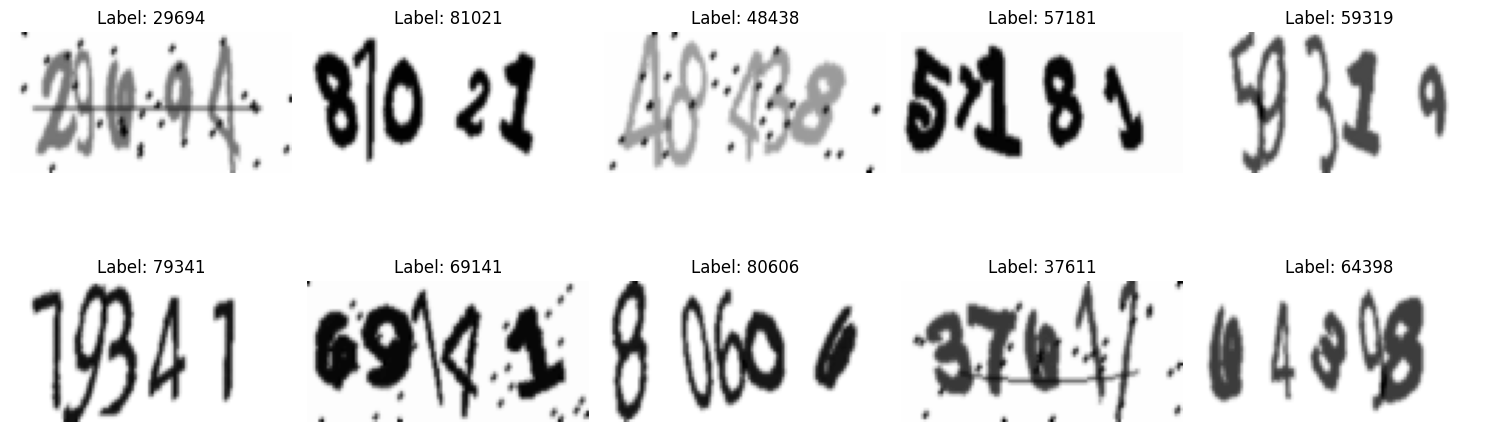

In [11]:
# 1. Display Preprocessed CAPTCHA Samples
# Purpose: Visualize preprocessed CAPTCHA samples to ensure correct resizing and normalization.
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    idx = random.randint(0, len(X_train) - 1)
    axes[i].imshow(X_train[idx].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {decode_predictions([y_train[idx]])[0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

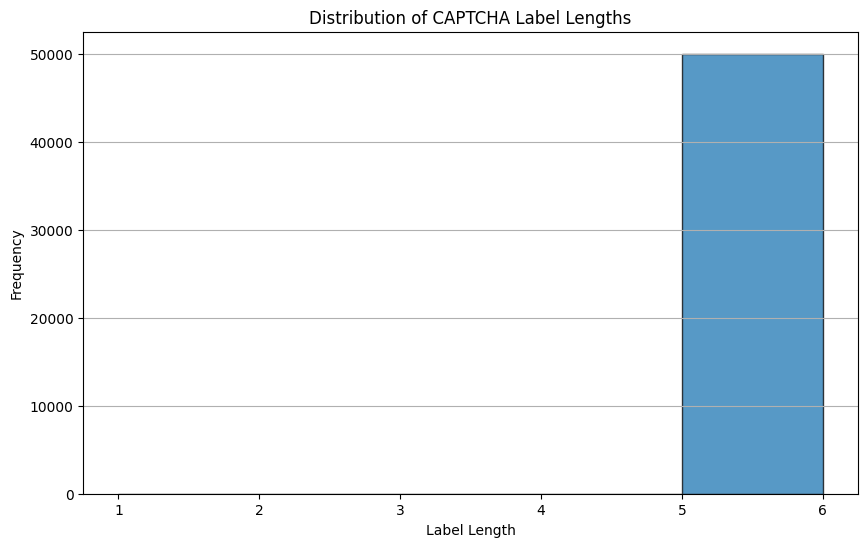

In [12]:
# 2. Label Length Distribution
# Purpose: Understand the distribution of label lengths in the dataset to verify padding requirements.
label_lengths = [len(label) for label in y]
plt.figure(figsize=(10, 6))
plt.hist(label_lengths, bins=range(1, max_length + 2), edgecolor='black', alpha=0.75)
plt.title('Distribution of CAPTCHA Label Lengths')
plt.xlabel('Label Length')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [13]:
# 3. Training History
# Purpose: Monitor the training and validation accuracy/loss over epochs to evaluate performance.
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

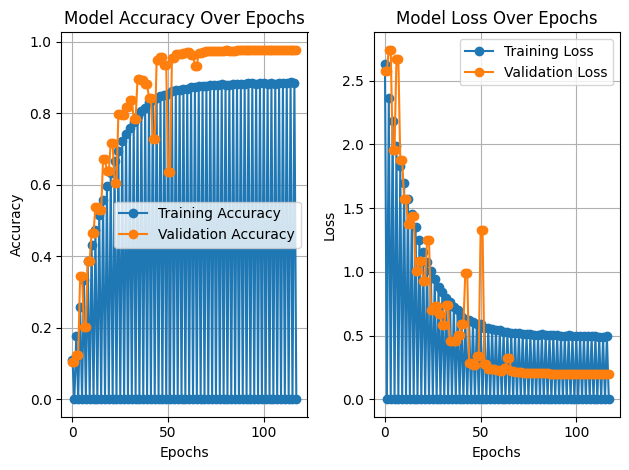

In [14]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

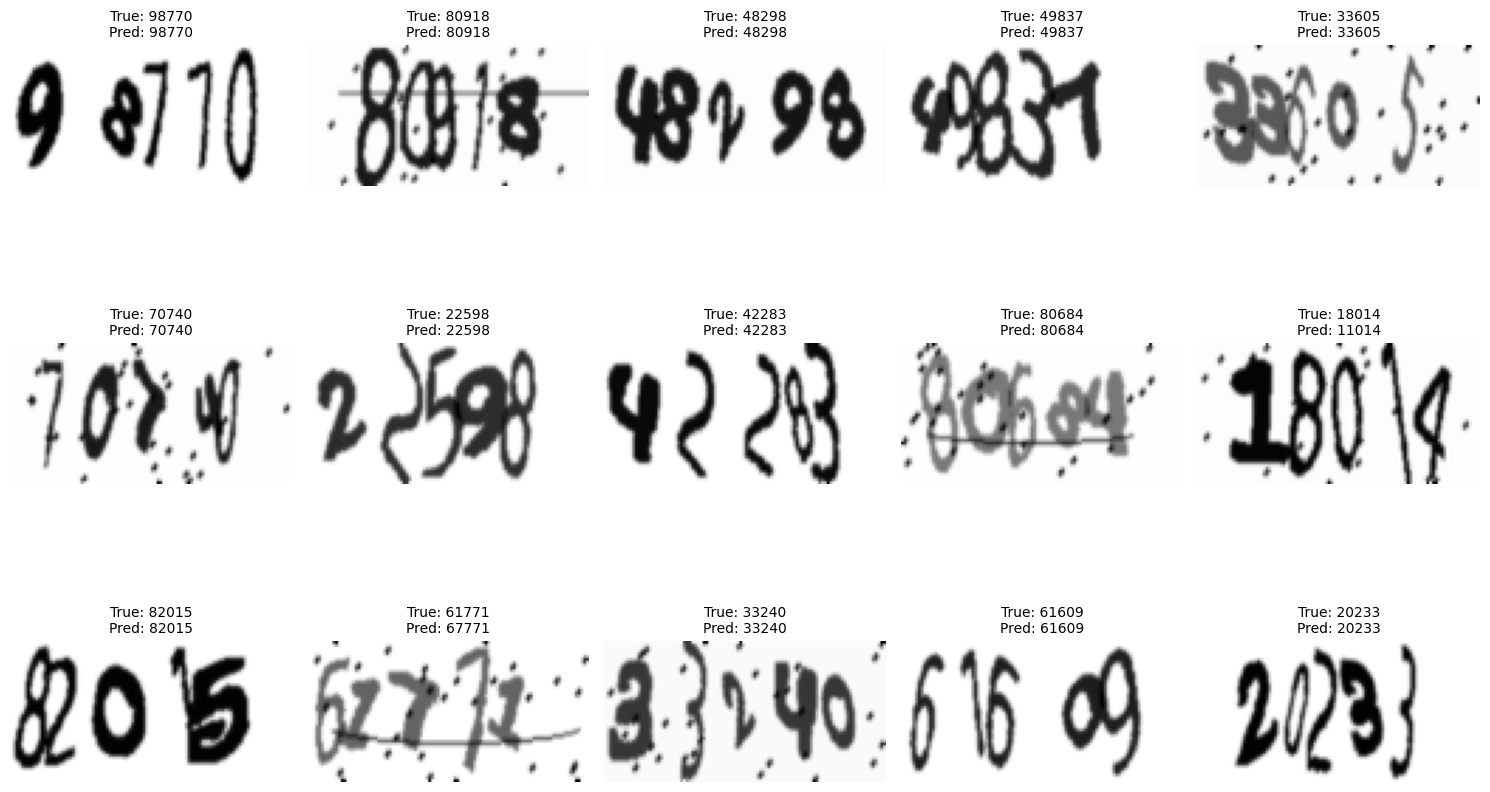

In [15]:
# 4. Model Predictions vs Ground Truth
# Purpose: Compare model predictions with ground truth to identify common errors and performance visually.
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.ravel()

for i in range(15):
    idx = random.randint(0, len(X_test) - 1)
    axes[i].imshow(X_test[idx].squeeze(), cmap='gray')
    true_label = decode_predictions([y_test[idx]])[0]
    pred_label = decode_predictions([y_pred_probs[idx]])[0]
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

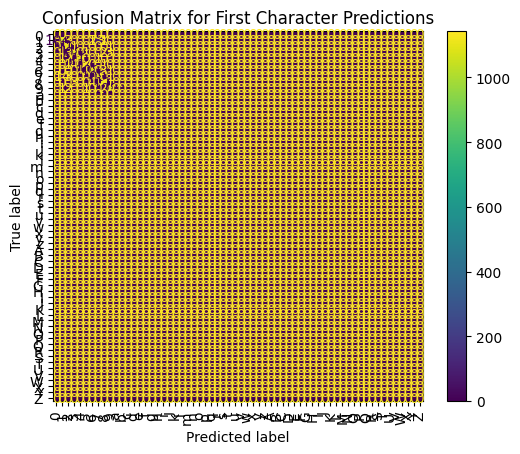

In [16]:
# 5. Confusion Matrix for First Characters
# Purpose: Identify confusion patterns in the first character of predictions.
true_first_chars = [label[0] for label in decode_predictions(y_test)]
pred_first_chars = [label[0] for label in decode_predictions(y_pred_probs)]

conf_matrix = confusion_matrix(true_first_chars, pred_first_chars, labels=list(char_set))
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(char_set))
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='.0f')
plt.title('Confusion Matrix for First Character Predictions')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


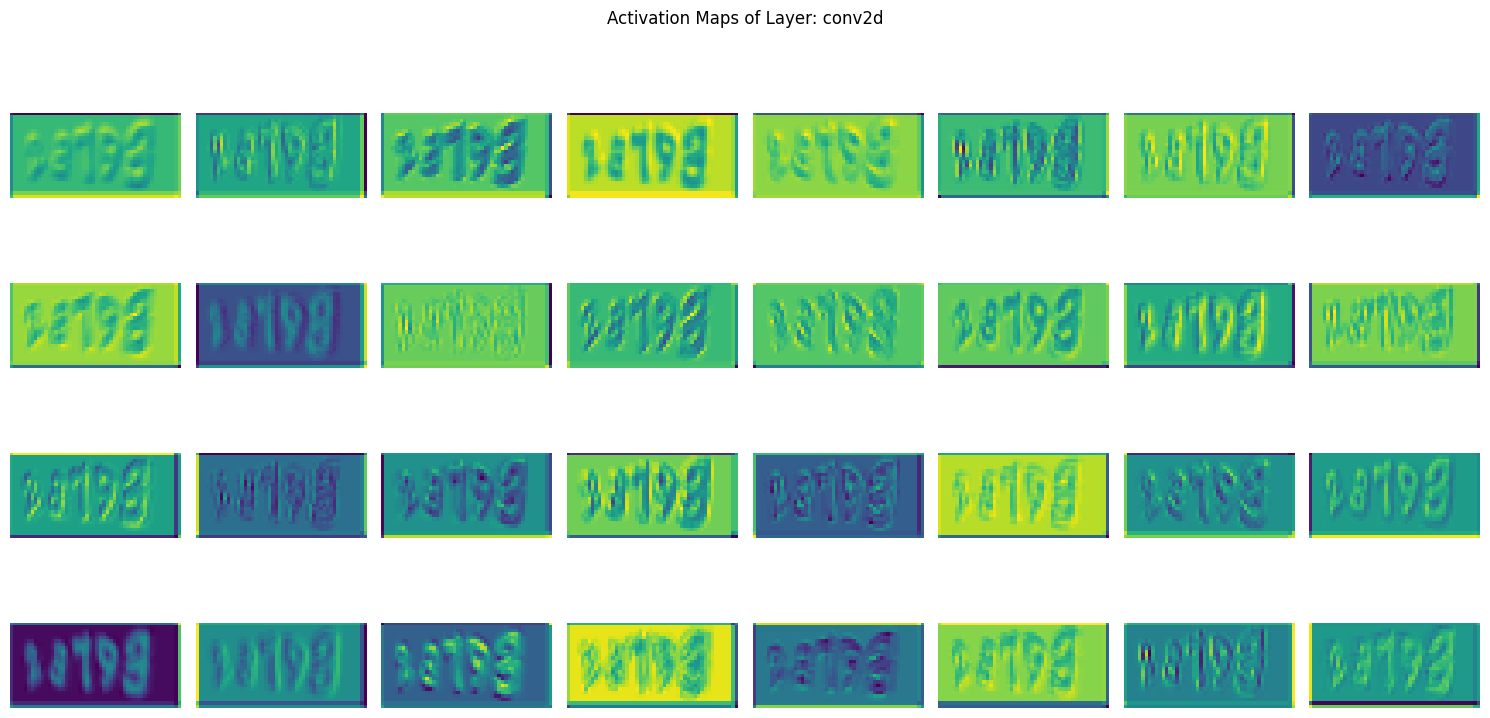

In [17]:
# 6. Activation Map Visualization
# Purpose: Visualize intermediate activation maps to understand what the model learns.
image_idx = random.randint(0, len(X_test) - 1)
test_image = X_test[image_idx:image_idx+1]

# Extracting outputs of convolutional layers
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_image)

# Plot activations of the first convolutional layer
layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]
first_layer_activations = activations[0]

fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.ravel()

for i in range(32):  # Visualize first 32 filters
    axes[i].imshow(first_layer_activations[0, :, :, i], cmap='viridis')
    axes[i].axis('off')

plt.suptitle(f"Activation Maps of Layer: {layer_names[0]}")
plt.tight_layout()
plt.show()